# Set-up

In [3]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
import timeit
import itertools
import pickle
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy.sparse import hstack

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
 from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes et fonctions

In [43]:
DICT_COLS = {'Title': [50, 1500, 500], 'Body': [100, 3000, 1000]}
SAMPLE = 5000
RATIO = 1/3

def tag_question(title, body=''):
    """
    Prediction function of stackexchange tags from a query passed as parameter
    """ 

    tokenizer = nltk.RegexpTokenizer(REGEX)
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer()

    title = clean_field(title, tknzr=tokenizer, sw=std_sw, \
                        lmtzr=lemmatizer, stmr=stemmer)
    title = ' '.join([w for w in title.split() \
                       if w not in EXTRA_SW and not w.isdigit()])

    body = clean_field(body, tknzr=tokenizer, sw=std_sw, \
                       lmtzr=lemmatizer, stmr=stemmer)
    body = ' '.join([w for w in body.split() \
                      if w not in EXTRA_SW and not w.isdigit()])
    
    tfidf_t = tfidf['Title'].transform([title])
    #features_t = tfidf['Title'].get_feature_names()

    tfidf_b = tfidf['Body'].transform([body])
    #features_b = tfidf['Body'].get_feature_names()

    tfidf_full = hstack([tfidf_t, tfidf_b])

    return get_tags(label.classes_, model.predict(tfidf_full)[0])
    
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''

    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

def get_tags(features, pred):
    """ 
    Fonction de récupératon des libellés des tags à partir de la prédiction
    """

    temp = set()

    for i in range(len(pred)):
        if pred[i] == 1:
            temp.update([features[i]])

    return '<{}>'.format('><'.join(sorted(temp)))

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = []
    
    for w in tknzr.tokenize(col.lower()):
        if w not in sw and not w.isdigit():
            pos = get_wordnet_pos(w)
            if pos != 'n':
                continue
            else:
                temp.append(stmr.stem(lmtzr.lemmatize(w, pos)))
            
    return ' '.join(temp)

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def print_top10(feature_names, clf, class_labels):
    """
    Prints features with the highest coefficient values, per class
    """

    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("{}: {}\n{}".format(class_label,
                              " ".join(feature_names[j] for j in top10), 
                              "-" * 30))

# Chargement

In [6]:
freq = defaultdict()

with open('OC_DS_P6_backup.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    source = unpickler.load()
    EXTRA_SW = unpickler.load()
    REGEX = unpickler.load()

freq = recap_cols(source, source.columns)

source.head()

Dénombrenent des mots
	Title  :  256593 dont   9998 distincts
	Body   : 1492769 dont  46197 distincts
	top_tags :  104592 dont    100 distincts


,Title,Body,top_tags
64767087,git data model,read understand git work hood diagram book git...,git
63429629,calcul v sql server result,simpl calcul sum eom count result valu calcul ...,sql sql-server
63072035,happen child branch merg parent branch master,think question elabor branch branch happen bra...,git
62824936,refer default constructor c# result cs8618,c# class default constructor design declar def...,c#
60928038,string datetim day week incorrect,simpl line code code day week throw except mon...,.net c# datetime


In [7]:
len(source.top_tags.unique())

3952

In [8]:
train = source.copy()
dict_precision = {}

# TF-IDF
Je crée un dictionnaire avec les vecteurs TFIDF pour les appeler dans la fonction finale

In [9]:
DICT_VECTOR = {'Title': [100, 1500, 500], 'Body': [200, 3000, 1000]}

In [10]:
dict_tfidf = defaultdict(dict)

for col in DICT_VECTOR.keys():
    X = train[col]

    dict_tfidf['vector'][col] = TfidfVectorizer(token_pattern=REGEX, \
                                                stop_words=EXTRA_SW, \
                                                min_df=DICT_VECTOR[col][0], \
                                                #max_df=DICT_VECTOR[col][1], \
                                                max_features=1000\
                                                ).fit(X)
                                                #DICT_COLS[col][2])
                                                
    #v_tfidf = dict_tfidf['vector'][col].transform(X)
    cols = dict_tfidf['vector'][col].get_feature_names()
    #dict_tfidf['df'][col] = pd.DataFrame(v_tfidf.todense().tolist(), \
    #                                     columns=cols, index=train.index)
    #print(col, ':', dict_tfidf['df'][col].shape)
    print(len(cols), cols)

408 ['2d', 'access', 'across', 'address', 'aggreg', 'ajax', 'algorithm', 'android', 'angular', 'anim', 'anoth', 'api', 'app', 'append', 'applic', 'argument', 'array', 'asp', 'assign', 'async', 'attribut', 'avoid', 'aw', 'awk', 'axi', 'b', 'background', 'bar', 'base', 'bash', 'behavior', 'binari', 'bind', 'block', 'boolean', 'box', 'bracket', 'branch', 'build', 'button', 'byte', 'c', 'c#', 'c++', 'calcul', 'call', 'cannot', 'captur', 'case', 'categori', 'cell', 'chang', 'char', 'charact', 'chart', 'check', 'checkbox', 'child', 'class', 'claus', 'click', 'code', 'collect', 'color', 'column', 'combin', 'comma', 'command', 'commit', 'compar', 'comparison', 'compil', 'compon', 'concaten', 'condit', 'connect', 'const', 'constructor', 'contain', 'content', 'control', 'convert', 'copi', 'core', 'correct', 'count', 'cs', 'csv', 'custom', 'd3', 'dart', 'data', 'databas', 'datafram', 'dataset', 'date', 'datetim', 'day', 'db', 'decim', 'declar', 'default', 'defin', 'delet', 'depend', 'detect', 'df

In [11]:
X_title = dict_tfidf['vector']['Title'].fit_transform(train.Title)
X_body = dict_tfidf['vector']['Body'].fit_transform(train.Body)
X = hstack([X_title, X_body])

features_names = dict_tfidf['vector']['Title'].get_feature_names() + dict_tfidf['vector']['Body'].get_feature_names()
len(features_names)

1173

# LDA

In [46]:
no_topics = 100

In [47]:
dict_precision["lda"] = {}
params = {'n_components' : np.arange(100, 1000, 100), 'learning_decay': [.5, .7, .9]}

print('{}\nLDA\t'.format('='*30), end='')

start_time = timeit.default_timer()
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

#gs = GridSearchCV(clf, params)
clf = lda.fit(X)
elapsed = timeit.default_timer() - start_time
print("{:.2f}s\n".format(elapsed))    

#print("Best params:", gs.best_params_, '\n')
dict_precision["lda"]['clf'] = clf

LDA	84.56s



In [49]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}: {} -> ".format(topic_idx, 
                                        feature_names[topic.argsort()[-1]]), 
              end='')
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('-' * 30)

no_top_words = 10
display_topics(clf, features_names, no_top_words)

Topic 0: commit -> commit commit chang chang file two git git entri two
------------------------------
Topic 1: countri -> countri consist email direct parent tool via coupl issu calcul
------------------------------
Topic 2: button -> button click button click page access event page event menu
------------------------------
Topic 3: column -> column panda datafram column datafram valu valu df row panda
------------------------------
Topic 4: v -> v found concaten fix game concaten learn macro deal beginn
------------------------------
Topic 5: r -> r plot plot r data ggplot df awk point point
------------------------------
Topic 6: cell -> cell cell variabl two one everi variabl per spreadsheet multipl
------------------------------
Topic 7: state -> state git git import retriev foo branch commit import commit
------------------------------
Topic 8: paramet -> paramet paramet ggplot2 inherit u regard resolv setup pa argument
------------------------------
Topic 9: net -> net perl core

# Clustering

PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X_trans = pca.fit_transform(X.todense())

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.02160398 0.01414365] 0.0357476364475137


best clustering =  250 elapsed :  2129.16008319


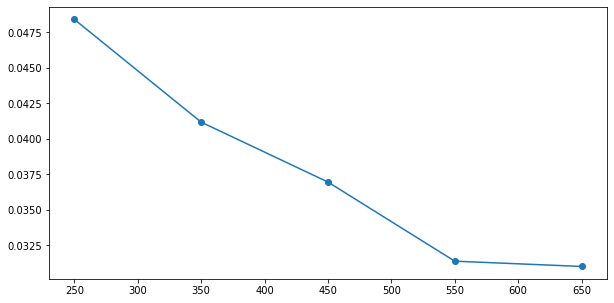

In [ ]:
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(250, 750, 100)

start_time = timeit.default_timer()
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1)
    myclust.fit(X)
    silhouettes.append(metrics.silhouette_score(X, myclust.labels_))

elapsed = timeit.default_timer() - start_time
best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster, 'elapsed : ', elapsed)

fig = plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouettes, marker='o')

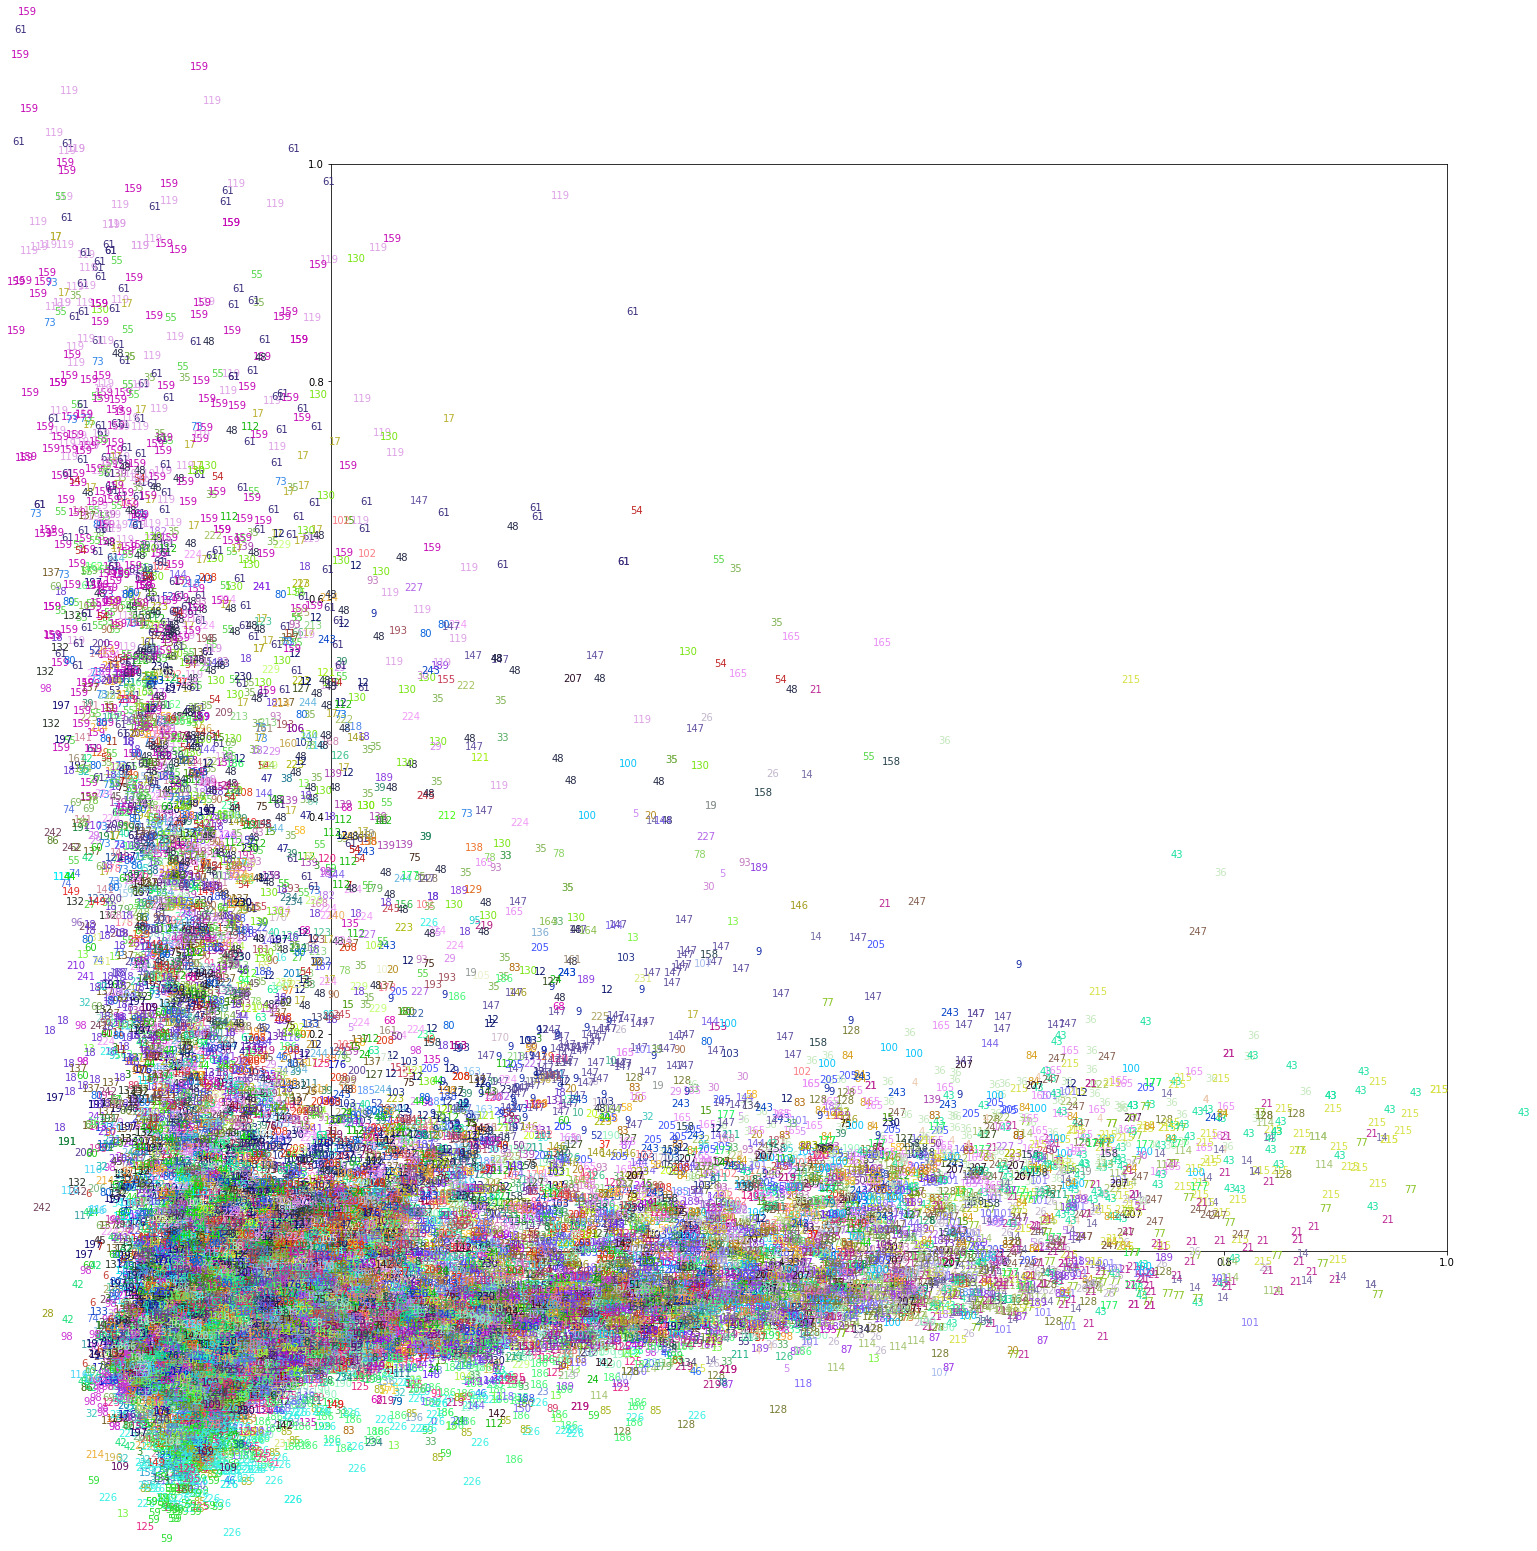

Silhouette Coefficient: 0.048


In [ ]:
nb_clusters = 250
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters, random_state=1)
myclust.fit(X)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
#plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
#plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
tfidf[tfidf.cluster == 4][['cluster']].merge(train[['Title', 'Body', 'top_tags']], left_index=True, right_index=True)

,cluster,Title,Body,top_tags
59622045,4,datafram multipl valu key,beginn panda datafram datafram look approach r...,dataframe pandas python
59632163,4,spread datafram valu column name fill count ce...,datafram convert datafram datafram spread data...,dataframe r
59685902,4,panda datafram modifi valu datafram condit,datafram chang valu contain bracket number rem...,pandas python
59762900,4,concaten datafram import duplic row datafram,datafram concaten t4 t5 present datafram valu ...,pandas python
59787083,4,datafram structur,datafram rearrang datafram,dataframe pandas python python-3.x
...,...,...,...,...
65809369,4,split datafram group product,split datafram datafram product datafram look ...,pandas python
65979102,4,filter datafram data type tupl,datafram reason data type datafram tupl list e...,pandas python
66330052,4,datafram consist string float,datafram df pd datafram abcd round decim place...,pandas python
66382435,4,panda datafram split one column multipl,datafram split charact col append column dataf...,dataframe pandas python


Plutôt que redéfinir les tags à partir des clusters calculés ci-dessus, je tente d'atteindre l'objectif par une classification supervisée

# Classification supervisée

In [15]:
DICT_CLF = {'lr': {'clf': LogisticRegression()},
            'svm': {'clf': LinearSVC(dual=False, max_iter=10000), 
                    'params': {'estimator__C': [1, 10, 100]}
                    },
            #'knn': {'clf': KNeighborsClassifier(),
            #        'params': {'n_neighbors': np.arange(100, 550, 100)}}, 
            'sgd': {'clf': SGDClassifier(), 
                    'params': {'estimator__loss': ['hinge', 'log', 
                                                   'modified_huber', 
                                                   'squared_hinge', 'perceptron'], 
                               'estimator__penalty': ['l2', 'l1']}}, 
            #'rfc': {'clf': RandomForestClassifier(), 
            #        'params': {'estimator__criterion': ['entropy', 'gini'], 
            #                   'estimator__n_estimators': [50, 100, 150, 200],}}, 
            }

## Multi-labelisation des top tags

In [16]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train.top_tags.str.split())
y = multilabel_binarizer.transform(train.top_tags.str.split())
y.shape

(52579, 100)

## Title
Commenté car chronophage  

In [ ]:
"""
X = dict_tfidf['vector']['Title'].transform(train.Title)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
"""

((7000, 85), (3000, 85), (7000, 100), (3000, 100))

In [ ]:
"""
dict_precision = {}

for k, v in DICT_CLF.items():
    clf = OneVsRestClassifier(v['clf'])
    clf_name = v['clf'].__class__.__name__
    print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
    dict_precision[clf_name] = {}

    start_time = timeit.default_timer()
#    gs = GridSearchCV(clf, v['params'], cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
#    print("Best params:", gs.best_params_, '\n')
    dict_precision[clf_name]['clf'] = clf

    y_pred = clf.predict(X_test)
    elapsed = timeit.default_timer() - start_time

    precision = 100*metrics.accuracy_score(y_test, y_pred)
    print("Title : time {:.2f}s".format(elapsed))    
    print("Accuracy: {:.2f}%".format(precision))    
    print("Jacard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

    dict_precision[clf_name]['precision'] = precision
    """

LinearSVC
------------------------------
Title : time 1.08s
Accuracy: 27.70%
Jacard score: 45.50

KNeighborsClassifier
------------------------------
Title : time 48.98s
Accuracy: 15.90%
Jacard score: 28.85

SGDClassifier
------------------------------
Title : time 0.72s
Accuracy: 27.83%
Jacard score: 44.87

RandomForestClassifier
------------------------------
Title : time 97.40s
Accuracy: 27.97%
Jacard score: 44.74



## Title + Body

In [17]:
X_title = dict_tfidf['vector']['Title'].transform(train.Title)
X_body = dict_tfidf['vector']['Body'].transform(train.Body)
X = hstack([X_title, X_body])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36805, 1173), (15774, 1173), (36805, 100), (15774, 100))

In [18]:
for k, v in DICT_CLF.items():
    clf = OneVsRestClassifier(v['clf'])
    clf_name = v['clf'].__class__.__name__
    print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
    dict_precision[clf_name] = {}

    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    dict_precision[clf_name]['clf'] = clf

    y_pred = clf.predict(X_test)
    elapsed = timeit.default_timer() - start_time

    precision = 100*metrics.accuracy_score(y_test, y_pred)
    print("Title+Body: time {:.2f}s".format(elapsed))    
    print("Accuracy: {:.2f}%".format(precision))    
    print("Jaccard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

    dict_precision[clf_name]['precision'] = precision

LogisticRegression
------------------------------
Title+Body: time 31.50s
Accuracy: 30.46%
Jacard score: 50.75

LinearSVC
------------------------------
Title+Body: time 11.80s
Accuracy: 33.17%
Jacard score: 54.66

SGDClassifier
------------------------------
Title+Body: time 6.65s
Accuracy: 31.59%
Jacard score: 51.35



In [19]:
clf = KNeighborsClassifier()
clf_name = clf.__class__.__name__
print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
dict_precision[clf_name] = {}

start_time = timeit.default_timer()
clf.fit(X_train, y_train)
dict_precision[clf_name]['clf'] = clf

y_pred = clf.predict(X_test)
elapsed = timeit.default_timer() - start_time

precision = 100*metrics.accuracy_score(y_test, y_pred)
print("Title+Body: time {:.2f}s".format(elapsed))    
print("Accuracy: {:.2f}%".format(precision))    
print("Jaccard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

dict_precision[clf_name]['precision'] = precision

KNeighborsClassifier
------------------------------
Title+Body: time 68.38s
Accuracy: 20.51%
Jacard score: 37.10



In [20]:
clf = RandomForestClassifier()
clf_name = clf.__class__.__name__
print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
dict_precision[clf_name] = {}

start_time = timeit.default_timer()
clf.fit(X_train, y_train)
dict_precision[clf_name]['clf'] = clf

y_pred = clf.predict(X_test)
elapsed = timeit.default_timer() - start_time

precision = 100*metrics.accuracy_score(y_test, y_pred)
print("Title+Body: time {:.2f}s".format(elapsed))    
print("Accuracy: {:.2f}%".format(precision))    
print("Jaccard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

dict_precision[clf_name]['precision'] = precision

RandomForestClassifier
------------------------------
Title+Body: time 380.57s
Accuracy: 36.55%
Jacard score: 53.59



# Optimisation du meilleur classifier
Je tente d'optimiser la SVM, qui a la meilleure performance

In [28]:
clf = DICT_CLF['svm']

In [33]:
print('{}\nBest classifier {}\t'.format('='*30, clf['clf'].__class__.__name__), end='')

start_time = timeit.default_timer()
gs = GridSearchCV(OneVsRestClassifier(clf['clf']), clf['params'], 
                  scoring=metrics.make_scorer(avg_jacard, greater_is_better=True))
print("{:.2f}s\n".format(timeit.default_timer() - start_time), end='')
gs.fit(X_train, y_train)
print("{:.2f}s\n".format(timeit.default_timer() - start_time))

Best classifier LinearSVC	0.00s
315.12s



In [34]:
print(gs.best_params_, '\n')

{'estimator__C': 1} 



In [35]:
print('{}\n{}\n{}'.format('='*30, 
                          gs.estimator.estimator.__class__.__name__, 
                          '-'*30))

y_pred = gs.predict(X_test)

precision = 100*metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(precision))    
print("Jacard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

LinearSVC
------------------------------
Accuracy: 33.17%
Jacard score: 54.66



# Matrices de confusion des tags dans le top20

In [36]:
# Index des tags les plus représentés
count_tag = y_test.sum(axis=0)
pos = count_tag.argsort()
idx_top20  = pos[-20:].tolist()
idx_top20.reverse()
idx_top20

[73, 46, 65, 75, 22, 74, 42, 8, 78, 14, 88, 45, 13, 47, 17, 77, 61, 96, 68, 59]

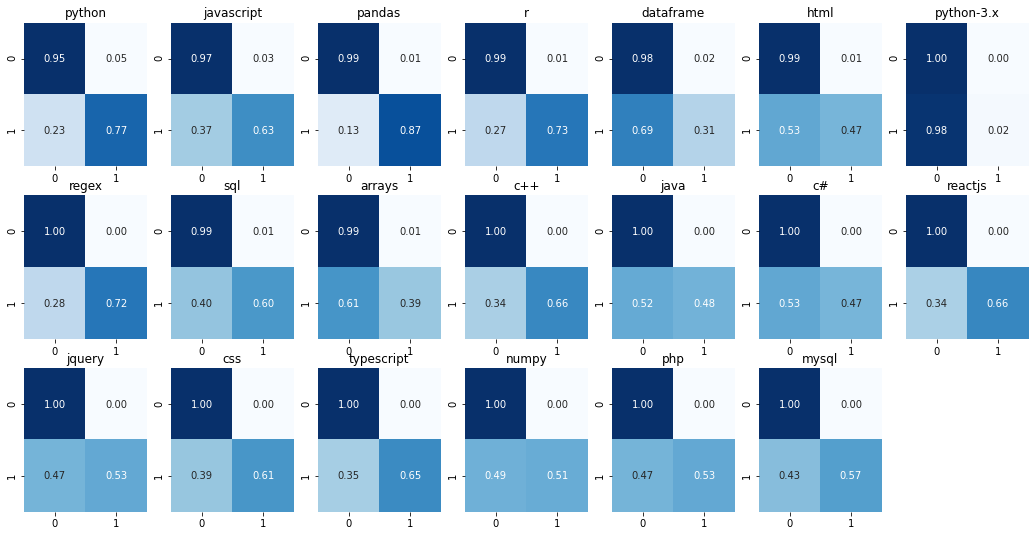

In [ ]:
from seaborn import heatmap
y_pred = dict_precision['LinearSVC']['clf'].predict(X_test)
estimator = dict_precision['LinearSVC']['clf']

fig = plt.figure(figsize=(18, 9))
cpt = 0
rg = 1

for i in idx_top20:
    cpt += 1
    plt.subplot(3, 7, cpt)
    plt.title(multilabel_binarizer.classes_[i])
    cm = metrics.confusion_matrix(y_test[:,i], y_pred[:,i], normalize='true')
    heatmap(cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='.2f')

# Top words des tags
Liste des 10 mots les plus fréquents pour attribuer chaque tag

In [44]:
feature_names = dict_tfidf['vector']['Title'].get_feature_names() + dict_tfidf['vector']['Body'].get_feature_names()
best_model = dict_precision['LinearSVC']['clf']
print_top10(feature_names, best_model, multilabel_binarizer.classes_)

.htaccess: stay regard index call attempt root redirect php rule htaccess
------------------------------
.net: guy compar applic foreach press proper open screenshot net net
------------------------------
ajax: control submit guid dropdown pars statu cant 1st ajax ajax
------------------------------
algorithm: squar usag reach n algorithm solut hidden forc approach algorithm
------------------------------
amazon-web-services: three public com report instanc mongodb configur instanc s3 aw
------------------------------
android: firebas network explan xml navig app layout activ android android
------------------------------
angular: usag experi servic weird modul browser compon t angular angular
------------------------------
apache-spark: minim record non updat maximum connect experi scala pyspark spark
------------------------------
arrays: coordin php unit comput usernam binari l postgresql array array
------------------------------
asp.net-core: start redirect log proper collect retr

# Export

In [ ]:
clf = 'LinearSVC'

with open('OC_DS_P6_prod.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(dict_tfidf['vector'])
    pickler.dump(dict_precision[clf]['clf'])
    pickler.dump(multilabel_binarizer)

# Test

In [ ]:
std_sw = set(stopwords.words('english')) 

tokenizer = RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

with open('OC_DS_P6_prod.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    tfidf = unpickler.load()
    model = unpickler.load()
    label = unpickler.load()

In [ ]:
titre1 = "Is there a method to loop array.map() function?"
corps1 = "<p>So, I have an array, which I'm showing on the screen using .map() function. How is it possible to make so, that when I'm reaching the last element, the next item after the last element will be the same as the first item? I'm thinking that it's possible to do by somehow looping map function, but I don't know how</p>"
corps1 = conv_html(corps1)
corps1

"So, I have an array, which I'm showing on the screen using .map() function. How is it possible to make so, that when I'm reaching the last element, the next item after the last element will be the same as the first item? I'm thinking that it's possible to do by somehow looping map function, but I don't know how"

In [ ]:
tag_question(titre1, corps1)

'<javascript><react-native>'

In [ ]:
tag_question('how running sql query in command line ?', 'I try to make an simple api for querying a database')

'<sql>'

In [ ]:
tag_question('refer default constructor c# result cs8618', 'c# class default constructor design declar def')

'<c#>'